# Sentiment Analysis on Amazon Product Reviews of Uplocked Mobile Phones

* #### [Part 1. Data Exploration](#part1) 
* #### [Part 2. Data Preparation](#part2) 
* #### [Part 3. Bag of Words](#part3)
* #### [Part 4. Word2Vec](#part4)
* #### [Part 5. LSTM](#part5)
* #### [Part 6. Word Cloud](#part6)

---
<a id="part1"></a>
## Part 1. Data Exploration

In [129]:
import pandas as pd
import numpy as np
from collections import Counter


import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from wordcloud import WordCloud

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.pipeline import Pipeline

from bs4 import BeautifulSoup  
import re
import nltk
from nltk.corpus import stopwords 
from nltk.stem.porter import PorterStemmer
from nltk.stem import SnowballStemmer, WordNetLemmatizer
from nltk import sent_tokenize, word_tokenize, pos_tag
from nltk.tokenize import PunktSentenceTokenizer  

import logging
import langdetect

from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Lambda, Embedding, LSTM, SimpleRNN, GRU
from tensorflow.keras.preprocessing.text import Tokenizer
from collections import defaultdict
from tensorflow.keras.layers import Conv1D  # Use Conv1D instead of Convolution1D
from tensorflow.keras import backend as K
from keras.utils import to_categorical
from tensorflow import keras
from keras import regularizers

from imblearn.under_sampling import RandomUnderSampler

### Load Data

In [130]:
# Load csv file
df = pd.read_csv('./amazon/data.csv')
df.head(4)

,Intel Core i9 (12th Gen) i9-12900F Hexadeca-core (16 Core) 2.40 GHz Processor - Retail Pack,Unnamed: 1,5.0,Reviewed in the United States on 17 September 2023,Omar Mendoza,Fast.
0,Intel Core i9 (12th Gen) i9-12900F Hexadeca-co...,NaN,5.0,Reviewed in the United States on 27 September ...,F. Machado,Fast CPU and since I did not need the graphics...
1,Intel Core i9 (12th Gen) i9-12900F Hexadeca-co...,NaN,5.0,Reviewed in the United States on 17 September ...,Omar Mendoza,Fast.
2,Intel Core i9 (12th Gen) i9-12900F Hexadeca-co...,NaN,5.0,Reviewed in the United States on 27 September ...,F. Machado,Fast CPU and since I did not need the graphics...
3,Intel Core i7-13700K Desktop Processor 16 core...,NaN,5.0,Reviewed in India on 3 September 2023,This processor is absolutely incredible with n...,This processor is absolutely incredible with n...


In [131]:
df = df.drop(columns=["Unnamed: 1"])
df.head()

,Intel Core i9 (12th Gen) i9-12900F Hexadeca-core (16 Core) 2.40 GHz Processor - Retail Pack,5.0,Reviewed in the United States on 17 September 2023,Omar Mendoza,Fast.
0,Intel Core i9 (12th Gen) i9-12900F Hexadeca-co...,5.0,Reviewed in the United States on 27 September ...,F. Machado,Fast CPU and since I did not need the graphics...
1,Intel Core i9 (12th Gen) i9-12900F Hexadeca-co...,5.0,Reviewed in the United States on 17 September ...,Omar Mendoza,Fast.
2,Intel Core i9 (12th Gen) i9-12900F Hexadeca-co...,5.0,Reviewed in the United States on 27 September ...,F. Machado,Fast CPU and since I did not need the graphics...
3,Intel Core i7-13700K Desktop Processor 16 core...,5.0,Reviewed in India on 3 September 2023,This processor is absolutely incredible with n...,This processor is absolutely incredible with n...
4,Intel Core i7-13700K Desktop Processor 16 core...,5.0,Reviewed in India on 28 March 2023,yogesh Kumar,Most powerful cpu at this price bracket no dou...


In [132]:
df.columns = ["Product", "Rating", "Demographic", "Reviewer", "Comments"]
df

,Product,Rating,Demographic,Reviewer,Comments
0,Intel Core i9 (12th Gen) i9-12900F Hexadeca-co...,5.0,Reviewed in the United States on 27 September ...,F. Machado,Fast CPU and since I did not need the graphics...
1,Intel Core i9 (12th Gen) i9-12900F Hexadeca-co...,5.0,Reviewed in the United States on 17 September ...,Omar Mendoza,Fast.
2,Intel Core i9 (12th Gen) i9-12900F Hexadeca-co...,5.0,Reviewed in the United States on 27 September ...,F. Machado,Fast CPU and since I did not need the graphics...
3,Intel Core i7-13700K Desktop Processor 16 core...,5.0,Reviewed in India on 3 September 2023,This processor is absolutely incredible with n...,This processor is absolutely incredible with n...
4,Intel Core i7-13700K Desktop Processor 16 core...,5.0,Reviewed in India on 28 March 2023,yogesh Kumar,Most powerful cpu at this price bracket no dou...
...,...,...,...,...,...
110996,Intel Bx80673I97940X CPU Grey,1.0,Reviewed in India on 17 June 2020,Santhosh Philip,Not at all working fake one
110997,Intel Bx80673I97940X CPU Grey,5.0,Reviewed in Italy on 19 November 2018,Cliente Amazon,Un mostro di processore
110998,Intel Bx80673I97940X CPU Grey,5.0,Reviewed in Germany on 2 July 2018,Henning,Zum Schneiden und Bearbeiten bestens geeignet....
110999,Intel Bx80673I97940X CPU Grey,5.0,Reviewed in Spain on 20 May 2019,Latinmau,Puro poder de procesador. Honestamente para lo...


In [133]:
df[['Location', 'Date']] = df['Demographic'].str.extract(r'Reviewed in (.*?) on (.*)')

df = df.drop(columns=["Demographic"])

df.columns = ["Product", "Rating", "Reviewer", "Reviews", "Location", "Date"]
df

,Product,Rating,Reviewer,Reviews,Location,Date
0,Intel Core i9 (12th Gen) i9-12900F Hexadeca-co...,5.0,F. Machado,Fast CPU and since I did not need the graphics...,the United States,27 September 2022
1,Intel Core i9 (12th Gen) i9-12900F Hexadeca-co...,5.0,Omar Mendoza,Fast.,the United States,17 September 2023
2,Intel Core i9 (12th Gen) i9-12900F Hexadeca-co...,5.0,F. Machado,Fast CPU and since I did not need the graphics...,the United States,27 September 2022
3,Intel Core i7-13700K Desktop Processor 16 core...,5.0,This processor is absolutely incredible with n...,This processor is absolutely incredible with n...,India,3 September 2023
4,Intel Core i7-13700K Desktop Processor 16 core...,5.0,yogesh Kumar,Most powerful cpu at this price bracket no dou...,India,28 March 2023
...,...,...,...,...,...,...
110996,Intel Bx80673I97940X CPU Grey,1.0,Santhosh Philip,Not at all working fake one,India,17 June 2020
110997,Intel Bx80673I97940X CPU Grey,5.0,Cliente Amazon,Un mostro di processore,Italy,19 November 2018
110998,Intel Bx80673I97940X CPU Grey,5.0,Henning,Zum Schneiden und Bearbeiten bestens geeignet....,Germany,2 July 2018
110999,Intel Bx80673I97940X CPU Grey,5.0,Latinmau,Puro poder de procesador. Honestamente para lo...,Spain,20 May 2019


In [134]:
distinct_values = df["Product"].unique()

print("Distinct values in Column1:")
for value in distinct_values:
    print(value)

Distinct values in Column1:
Intel Core i9 (12th Gen) i9-12900F Hexadeca-core (16 Core) 2.40 GHz Processor - Retail Pack
Intel Core i7-13700K Desktop Processor 16 cores (8 P-cores + 8 E-cores) 30M Cache, up to 5.4 GHz Socket LGA 1700
Intel Core i7 (12th Gen) i7-12700 Dodeca-core (12 Core) 2.10 GHz Processor - Retail Pack
Intel Core i9-13900K Desktop Processor LGA 1700 24 cores (8 P-cores + 16 E-cores) 36M Cache, up to 5.8 GHz'
Intel Core i7-13700KF Gaming Desktop Processor 16 cores (8 P-cores + 8 E-cores) - Unlocked
Intel® Core™ i9-13900KS Processor 36M Cache, up to 6.00 GHz
Intel® Core™ i9-14900KS Desktop Processor 24 cores (8 P-cores + 16 E-cores)
Intel CM8070104291318 Core I3-10100f 3.6ghz Lga1200 Chip Tray Cpu Mm 999wpa
Intel Core i9-12900K Desktop Processor16 (8P+8E) Cores up to 5.2 GHz Unlocked LGA1700 600 Series Chipset 125W
Intel Core i7 12700F 12 Gen Desktop PC Processor 12 Core CPU with 25MB Cache and up to 4.9 GHz Clock Speed LGA 1700 4K (Graphic Card Required)
Intel Core I5 

In [135]:
def extract_info(row):
    # Split the text by spaces
    parts = row.split()
    # Extract relevant information
    brand = parts[0]
    try:
        # Extracting model till 'Processor' for processors, 'Laptop' for laptops, 'Graphics' for graphics card, 'Camera' for camera, 'NUC' for mini pc, 'Motherboard' for Motherboard
        if 'Processor' in row:
            model = ' '.join(parts[1:parts.index('Processor')])
        else:
            model = 'N/A'
    except ValueError:
        # If the keyword is not found, set model as N/A
        model = 'N/A'
    return pd.Series([brand, model])

# Apply the function to the DataFrame and concatenate the results
df[['Brand', 'Model']] = df['Product'].apply(extract_info)

# Drop the original column
df.drop('Product', axis=1, inplace=True)

# Display the resulting DataFrame
print(df)

        Rating                                           Reviewer  \
0          5.0                                         F. Machado   
1          5.0                                       Omar Mendoza   
2          5.0                                         F. Machado   
3          5.0  This processor is absolutely incredible with n...   
4          5.0                                       yogesh Kumar   
...        ...                                                ...   
110996     1.0                                    Santhosh Philip   
110997     5.0                                     Cliente Amazon   
110998     5.0                                            Henning   
110999     5.0                                          Latinmau    
111000     5.0                               Mag Guenther Hofmann   

                                                  Reviews           Location  \
0       Fast CPU and since I did not need the graphics...  the United States   
1          

In [136]:
# Remove rows where Model is 'N/A'
df = df[df['Model'] != 'N/A']

# Remove rows where Brand doesn't come under Intel
intel_brands = ['Intel', 'Intel®', 'IntelCorei9-10900X', 'INTEL']
df = df[df['Brand'].isin(intel_brands)]

# Reset the index
df.reset_index(drop=True, inplace=True)

# Display the resulting DataFrame
df

,Rating,Reviewer,Reviews,Location,Date,Brand,Model
0,5.0,F. Machado,Fast CPU and since I did not need the graphics...,the United States,27 September 2022,Intel,Core i9 (12th Gen) i9-12900F Hexadeca-core (16...
1,5.0,Omar Mendoza,Fast.,the United States,17 September 2023,Intel,Core i9 (12th Gen) i9-12900F Hexadeca-core (16...
2,5.0,F. Machado,Fast CPU and since I did not need the graphics...,the United States,27 September 2022,Intel,Core i9 (12th Gen) i9-12900F Hexadeca-core (16...
3,5.0,This processor is absolutely incredible with n...,This processor is absolutely incredible with n...,India,3 September 2023,Intel,Core i7-13700K Desktop
4,5.0,yogesh Kumar,Most powerful cpu at this price bracket no dou...,India,28 March 2023,Intel,Core i7-13700K Desktop
...,...,...,...,...,...,...,...
67398,5.0,Js bibra,the review is good anyway being an intel produ...,India,14 July 2016,Intel,Core i7 6700K BX80662I76700K Socket LGA1151
67399,5.0,Amazon Customer,"good service by amazon, my pros. k380 , deepc...",India,4 December 2015,Intel,Core i7 6700K BX80662I76700K Socket LGA1151
67400,5.0,ankur goel,"Ultra fast 6th gen skylake processor , great f...",India,18 March 2016,Intel,Core i7 6700K BX80662I76700K Socket LGA1151
67401,5.0,SuperDrive,I have used several older models of NUC before...,the United States,11 July 2023,Intel,NUC 13 Pro NUC13ANHi7 Barebone System - Socket...


In [137]:
# Rearrange the columns
df = df[['Brand', 'Model', 'Rating', 'Date', 'Location','Reviewer','Reviews']]
df

,Brand,Model,Rating,Date,Location,Reviewer,Reviews
0,Intel,Core i9 (12th Gen) i9-12900F Hexadeca-core (16...,5.0,27 September 2022,the United States,F. Machado,Fast CPU and since I did not need the graphics...
1,Intel,Core i9 (12th Gen) i9-12900F Hexadeca-core (16...,5.0,17 September 2023,the United States,Omar Mendoza,Fast.
2,Intel,Core i9 (12th Gen) i9-12900F Hexadeca-core (16...,5.0,27 September 2022,the United States,F. Machado,Fast CPU and since I did not need the graphics...
3,Intel,Core i7-13700K Desktop,5.0,3 September 2023,India,This processor is absolutely incredible with n...,This processor is absolutely incredible with n...
4,Intel,Core i7-13700K Desktop,5.0,28 March 2023,India,yogesh Kumar,Most powerful cpu at this price bracket no dou...
...,...,...,...,...,...,...,...
67398,Intel,Core i7 6700K BX80662I76700K Socket LGA1151,5.0,14 July 2016,India,Js bibra,the review is good anyway being an intel produ...
67399,Intel,Core i7 6700K BX80662I76700K Socket LGA1151,5.0,4 December 2015,India,Amazon Customer,"good service by amazon, my pros. k380 , deepc..."
67400,Intel,Core i7 6700K BX80662I76700K Socket LGA1151,5.0,18 March 2016,India,ankur goel,"Ultra fast 6th gen skylake processor , great f..."
67401,Intel,NUC 13 Pro NUC13ANHi7 Barebone System - Socket...,5.0,11 July 2023,the United States,SuperDrive,I have used several older models of NUC before...


In [138]:
distinct_values = df["Model"].unique()

print("Distinct Processors being evaluated:")
for value in distinct_values:
    print(value)

Distinct Processors being evaluated:
Core i9 (12th Gen) i9-12900F Hexadeca-core (16 Core) 2.40 GHz
Core i7-13700K Desktop
Core i7 (12th Gen) i7-12700 Dodeca-core (12 Core) 2.10 GHz
Core i9-13900K Desktop
Core i7-13700KF Gaming Desktop
Core™ i9-13900KS
Core™ i9-14900KS Desktop
Core i7 12700F 12 Gen Desktop PC
Core I5 12400F 12 Gen Generation Desktop Pc
Core i5-13600K Desktop
Core i5 (12th Gen) i5-12500 3 GHz
Core i3-12100
Core i3 12100F 12th Gen Generation Desktop PC
Core i3-13100 Desktop
Core i5-14400F Desktop
NUC 13 Pro NUC13ANHi7 Barebone System - Socket BGA-1744-1 x
Core™ i7-14700KF New Gaming Desktop
Core i3-14100F Desktop
CoreTM i5-14600K LGA 1700 Socket New Gaming Desktop
Core i5-14500 Desktop
Core i5-14400 Desktop
Core™ i9-14900K New Gaming Desktop
Core i3-10100F 10th Generation LGA1200 Desktop
Core i7 12700 12th Gen Generation Desktop PC
Core I5-13400
Core I5-13400F
Core i5-12400 Desktop
Core I9-13900K
Pentium Gold G6405 10th Gen Generation Desktop PC
Core™ i9-13900F
Core i5 12

### Data Exploration

In [139]:
# Summary statistics of numerical features
print("Summary statistics of numerical features:\n", df.describe())

# Total number of reviews
total_reviews = len(df)
print("\nTotal number of reviews:", total_reviews)

# Total number of unique products
unique_products = len(df['Model'].unique())
print("\nTotal number of unique products:", unique_products)

# Percentage of reviews with neutral sentiment
neutral_percentage = (df[df['Rating'] == 3]["Reviews"].count() / total_reviews) * 100
print("\nPercentage of reviews with neutral sentiment: {:.2f}%".format(neutral_percentage))

# Percentage of reviews with positive sentiment
positive_percentage = (df[df['Rating'] > 3]["Reviews"].count() / total_reviews) * 100
print("\nPercentage of reviews with positive sentiment: {:.2f}%".format(positive_percentage))

# Percentage of reviews with negative sentiment
negative_percentage = (df[df['Rating'] < 3]["Reviews"].count() / total_reviews) * 100
print("\nPercentage of reviews with negative sentiment: {:.2f}%".format(negative_percentage))


Summary statistics of numerical features:
              Rating
count  67403.000000
mean       4.453704
std        1.205559
min        1.000000
25%        5.000000
50%        5.000000
75%        5.000000
max        5.000000

Total number of reviews: 67403

Total number of unique products: 96

Percentage of reviews with neutral sentiment: 2.69%

Percentage of reviews with positive sentiment: 85.83%

Percentage of reviews with negative sentiment: 10.45%


### Data Visualization 

Text(0, 0.5, 'Count')

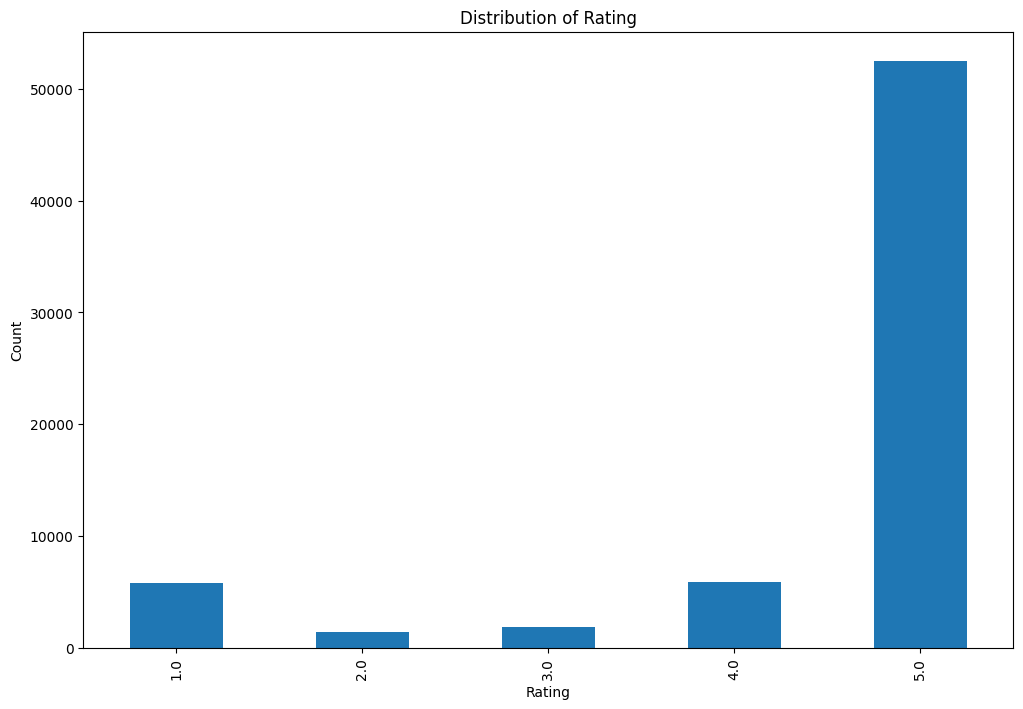

In [140]:
# Plot distribution of rating
plt.figure(figsize=(12,8))
# sns.countplot(df['Rating'])
df['Rating'].value_counts().sort_index().plot(kind='bar')
plt.title('Distribution of Rating')
plt.xlabel('Rating')
plt.ylabel('Count')

Text(0.5, 1.0, 'Number of Reviews for Top 20 Highest-Reviewed Processors')

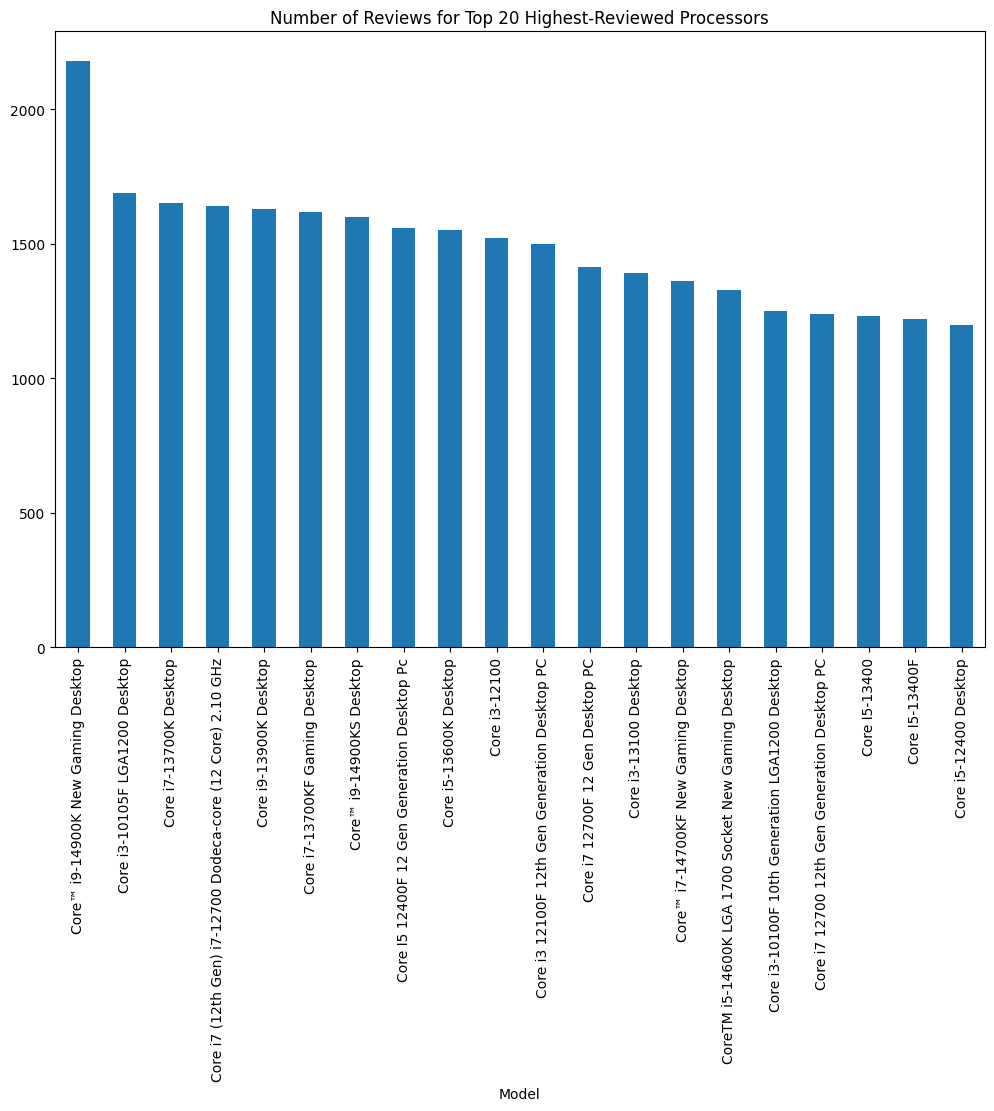

In [141]:
# Plot number of reviews for top 20 brands
brands = df["Model"].value_counts()
# brands.count()
plt.figure(figsize=(12,8))
brands[:20].plot(kind='bar')
plt.title("Number of Reviews for Top 20 Highest-Reviewed Processors")

Text(0.5, 1.0, 'Number of Reviews for Top 50 Highest-Reviewed Processors')

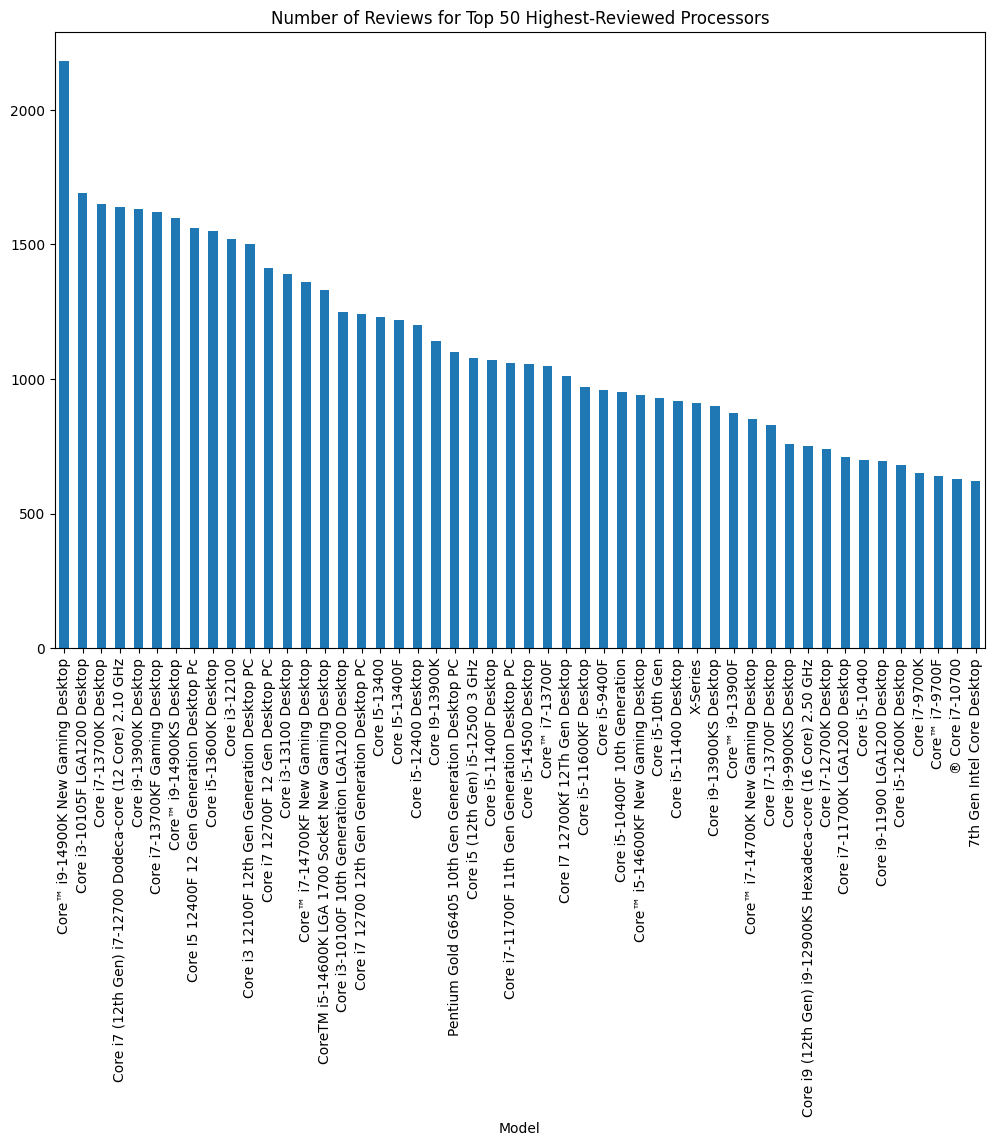

In [142]:
# Plot number of reviews for top 50 products
products = df["Model"].value_counts()
plt.figure(figsize=(12,8))
products[:50].plot(kind='bar')
plt.title("Number of Reviews for Top 50 Highest-Reviewed Processors")

Text(0, 0.5, 'Count')

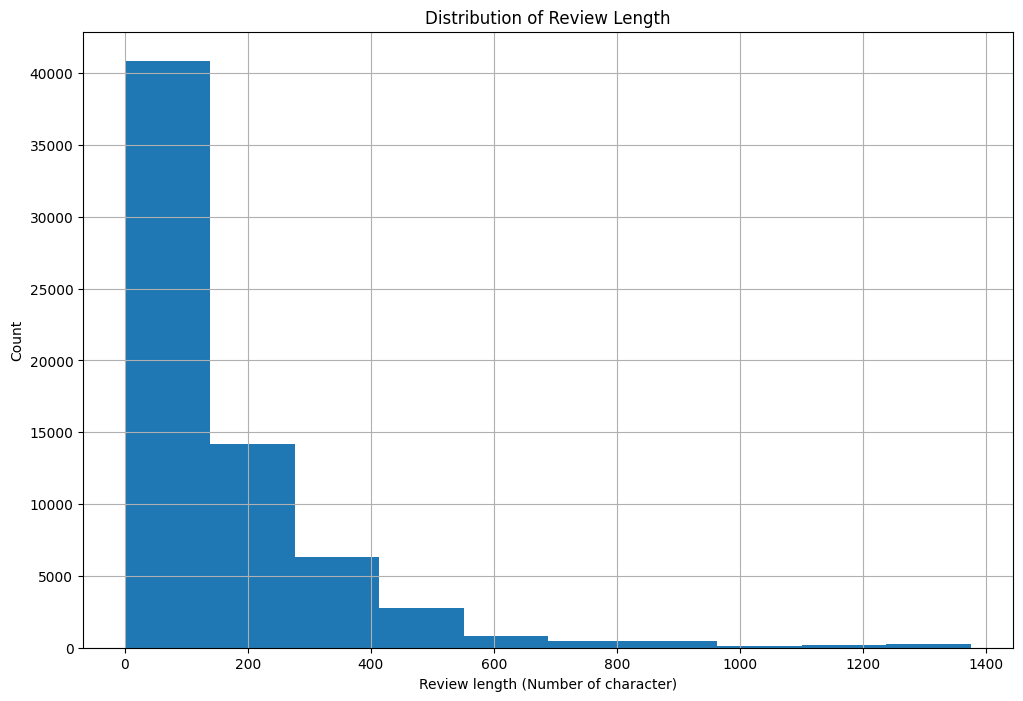

In [143]:
# Plot distribution of review length
review_length = df["Reviews"].dropna().map(lambda x: len(x))
plt.figure(figsize=(12,8))
review_length.loc[review_length < 1500].hist()
plt.title("Distribution of Review Length")
plt.xlabel('Review length (Number of character)')
plt.ylabel('Count')

---
<a id="part2"></a>
## Part 2. Data Preparation

For illustrative purpose, I use only 10% of the data in this project. To simply the problem, I only consider reviews with positive sentiment (rating = 4, 5) and negative sentiment (rating = 1, 2), and drop reviews with neutral sentiment (rating 3). 


### Prepare Data

In [204]:
df = df.sample(frac=0.7, random_state=0) #uncomment to use full set of data

# Drop missing values
df.dropna(inplace=True)

# Remove any 'neutral' ratings equal to 3
df = df[df['Rating'] != 3]

# Encode 4s and 5s as 1 (positive sentiment) and 1s and 2s as 0 (negative sentiment)
df['Sentiment'] = np.where(df['Rating'] > 3, 1, 0)
df.head(40)

,Brand,Model,Rating,Date,Location,Reviewer,Reviews,Sentiment
64924,Intel®,Core™ i9-9980XE Extreme Edition,5.0,2019-11-24,the United Kingdom,Ionut,A very good CPU and it runs with 64GB ram GSki...,1
53996,Intel,Core I7-13700F Desktop,5.0,2023-07-06,the United States,M. Thompson,Had to return mine.. was simply too much power...,1
54380,Intel,Core i5 (12th Gen) i5-12500 3 GHz,5.0,2022-10-29,the United States,Raymond KIMATHI,Very good for HTPC. With two media engines for...,1
19365,Intel,Core i3-10105F LGA1200 Desktop,5.0,2021-11-16,Australia,Lorenzo Ruiz,"Was tired of salvaging old pc parts, just not ...",1
47595,Intel,Core i5-11400 Desktop,4.0,2024-04-12,India,Aman,Product is safe or good but packaging 📦 is not...,1
12399,Intel®,Core i3-12100,5.0,2023-10-20,India,Placeholder,mast hai bhai le lo working is good.,1
30086,Intel,Core i9-13900K Desktop,5.0,2023-09-24,India,Gurjant Singh,Thanks 🙏,1
57872,Intel®,Core™ i9-9960X X-Series,5.0,2019-12-27,the United States,Scarlett,Good processor,1
54429,Intel,Core i3-14100F Desktop,5.0,2024-02-26,the United States,Jorge Mendoza,Worked perfectly for fortnite and comes with a...,1
39291,Intel®,Core i3-12100,1.0,2023-09-14,India,Amazon Customer,"Can't launch even a small game, hangs all the ...",0


In [206]:
def is_english(text):
  """Checks if the text is in English using langdetect"""
  try:
    return langdetect.detect(text) == 'en'
  except langdetect.LangDetectException:  # Handle potential errors
    return False

# Drop rows with missing reviews or non-English reviews
df = df[df['Reviews'].notnull() & df['Reviews'].apply(is_english)]

# View the first 40 rows after cleaning
df.head(40)

,Brand,Model,Rating,Date,Location,Reviewer,Reviews,Sentiment
64924,Intel®,Core™ i9-9980XE Extreme Edition,5.0,2019-11-24,the United Kingdom,Ionut,A very good CPU and it runs with 64GB ram GSki...,1
53996,Intel,Core I7-13700F Desktop,5.0,2023-07-06,the United States,M. Thompson,Had to return mine.. was simply too much power...,1
54380,Intel,Core i5 (12th Gen) i5-12500 3 GHz,5.0,2022-10-29,the United States,Raymond KIMATHI,Very good for HTPC. With two media engines for...,1
19365,Intel,Core i3-10105F LGA1200 Desktop,5.0,2021-11-16,Australia,Lorenzo Ruiz,"Was tired of salvaging old pc parts, just not ...",1
47595,Intel,Core i5-11400 Desktop,4.0,2024-04-12,India,Aman,Product is safe or good but packaging 📦 is not...,1
12399,Intel®,Core i3-12100,5.0,2023-10-20,India,Placeholder,mast hai bhai le lo working is good.,1
30086,Intel,Core i9-13900K Desktop,5.0,2023-09-24,India,Gurjant Singh,Thanks 🙏,1
57872,Intel®,Core™ i9-9960X X-Series,5.0,2019-12-27,the United States,Scarlett,Good processor,1
54429,Intel,Core i3-14100F Desktop,5.0,2024-02-26,the United States,Jorge Mendoza,Worked perfectly for fortnite and comes with a...,1
39291,Intel®,Core i3-12100,1.0,2023-09-14,India,Amazon Customer,"Can't launch even a small game, hangs all the ...",0


In [207]:
df.shape

(26326, 8)

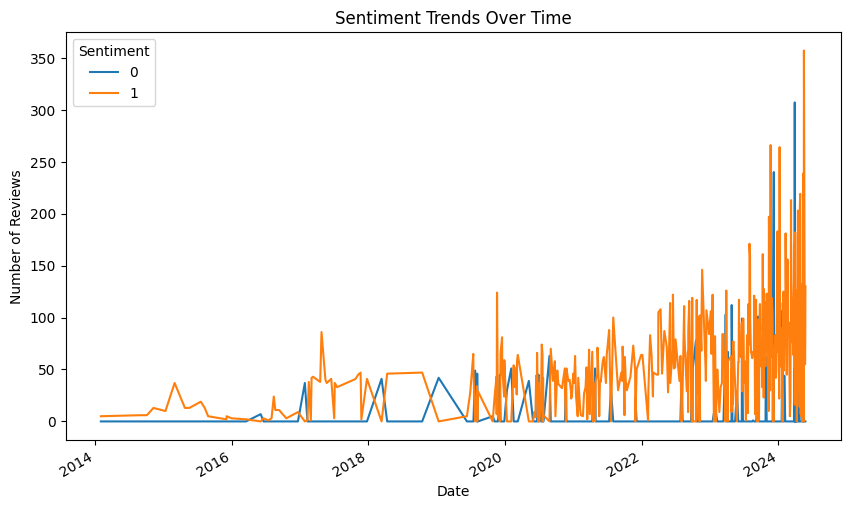

In [208]:
# Convert 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Group data by date and sentiment, count occurrences, and unstack the result
sentiment_trend = df.groupby(['Date', 'Sentiment']).size().unstack(fill_value=0)

# Plot the sentiment trends over time
sentiment_trend.plot(kind='line', figsize=(10, 6))

# Add title and labels
plt.title('Sentiment Trends Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Reviews')

# Show plot
plt.show()


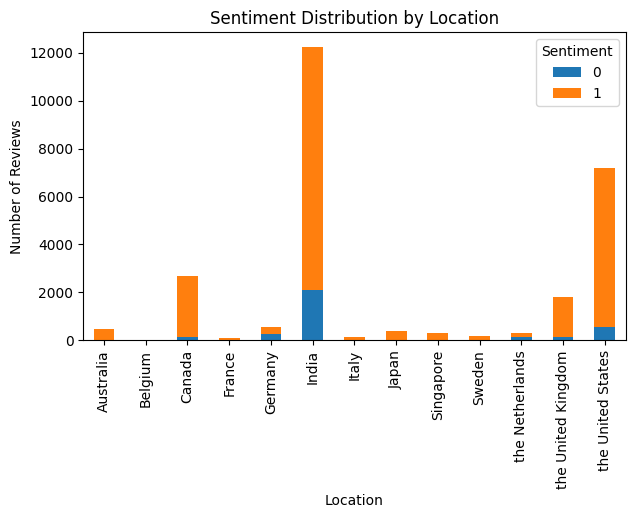

In [209]:
location_sentiment_count = df.groupby(['Location', 'Sentiment']).size().unstack(fill_value=0)

# Plot the sentiment counts for each location
location_sentiment_count.plot(kind='bar', stacked=True, figsize=(7, 4))

# Add title and labels
plt.title('Sentiment Distribution by Location')
plt.xlabel('Location')
plt.ylabel('Number of Reviews')

# Show legend
plt.legend(title='Sentiment')

# Show plot
plt.show()

In [210]:
# Assuming your DataFrame is named 'df'
text_reviews = df['Reviews'].tolist()  # Adjust column name if different
sentiment = df['Sentiment'].apply(lambda x: int(x)).tolist()  # Adjust column name if different

# Combine text and sentiment into a single list of tuples
data = list(zip(text_reviews, sentiment))

# Check class distribution before undersampling
class_counts = dict(Counter(sentiment))
print("Class Distribution Before Undersampling:")
print(class_counts)

# Undersample the majority class (assuming class 1 is majority)
rus = RandomUnderSampler(sampling_strategy={1: class_counts[0]})  # Adjust for minority class if needed
data_resampled, _ = rus.fit_resample(data, [label for _, label in data])

# Separate text and sentiment after undersampling
text_reviews_resampled, sentiment_resampled = zip(*data_resampled)
sentiment_resampled = [int(x) for x in sentiment_resampled]

Class Distribution Before Undersampling:
{1: 22970, 0: 3356}


### Train Test Split 

In [211]:
# Split data into training and validation sets (ensure NumPy arrays)
X_train, X_test, y_train, y_test = train_test_split(text_reviews_resampled, sentiment_resampled,
                                                   test_size=0.1, random_state=71)

print('Loaded %d training examples and %d validation examples. \n' % (len(X_train), len(X_test[0])))
print('Sample review in the training set: \n', X_train[10])  
# Calculate class distribution after undersampling
class_counts_after = dict(Counter(sentiment_resampled))
print("\nClass Distribution After Undersampling:")
print(class_counts_after)


Loaded 6040 training examples and 263 validation examples. 

Sample review in the training set: 
 You won't get display without graphic card. Extra 4-5k pay for Graphic card, is it good dear Intel. U r Chor Intel.

Class Distribution After Undersampling:
{0: 3356, 1: 3356}


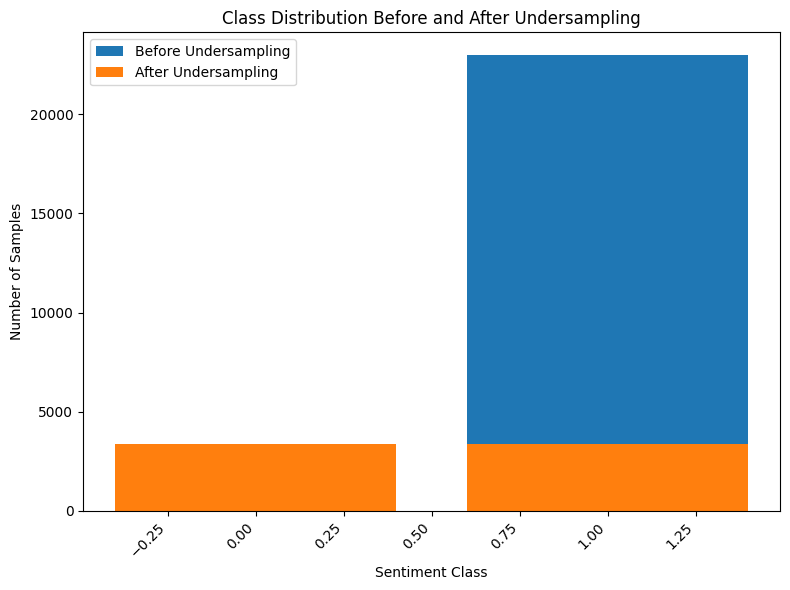

In [212]:
# Plot class distribution before and after undersampling (assuming numerical labels)
plt.figure(figsize=(8, 6))

# If class labels are strings, convert them to numerical values for plotting
if isinstance(list(class_counts.keys())[0], str):
    label_mapping = {label: i for i, label in enumerate(set(class_counts.keys()))}
    class_counts_before = {label_mapping[label]: count for label, count in class_counts.items()}
    class_counts_after = {label_mapping[label]: count for label, count in class_counts_after.items()}

plt.bar(class_counts.keys(), class_counts.values(), label='Before Undersampling')
plt.bar(class_counts_after.keys(), class_counts_after.values(), label='After Undersampling')
plt.xlabel('Sentiment Class')
plt.ylabel('Number of Samples')
plt.title('Class Distribution Before and After Undersampling')
plt.legend()
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

In [213]:
print("Type of y_train:", type(y_train[0]))
print("Type of y_test:", type(y_test[0]))


Type of y_train: <class 'int'>
Type of y_test: <class 'int'>


---
<a id="part3"></a>
## Part 3. Bag of Words

The goal of this project is to classify the reviews into positive and negative sentiment. There are two main steps involved. First, we need to find a word embedding to convert a text into a numerical representation. Second, we fit the numerical representations of text to machine learning algorithms or deep learning architectures.

One common approach of word embedding is frequency based embedding such as Bag of Words (BoW) model. BoW model learns a vocubulary list from a given corpus and represents each document based on some counting methods of words. In this part, we will explore the model performance of using BoW with supervised learning algorithms. Here's the workflow in this part.

* Step 1 : Preprocess raw reviews to cleaned reviews
* Step 2 : Create BoW using CountVectorizer / Tfidfvectorizer in sklearn
* Step 3 : Transform review text to numerical representations (feature vectors)
* Step 4 : Fit feature vectors to supervised learning algorithm (eg. Naive Bayes, Logistic regression, etc.)
* Step 5 : Improve the model performance by GridSearch

### Text Preprocessing

The following text preprocessing are implemented to convert raw reviews to cleaned review, so that it will be easier for us to do feature extraction in the next step.
* remove html tags using BeautifulSoup
* remove non-character such as digits and symbols
* convert to lower case
* remove stop words such as "the" and "and" if needed
* convert to root words by stemming if needed

In [214]:
def cleanText(raw_text, remove_stopwords=False, stemming=False, split_text=False, \
             ):
    '''
    Convert a raw review to a cleaned review
    '''
    text = BeautifulSoup(raw_text, 'lxml').get_text()  #remove html
    letters_only = re.sub("[^a-zA-Z]", " ", text)  # remove non-character
    words = letters_only.lower().split() # convert to lower case 
    
    if remove_stopwords: # remove stopword
        stops = set(stopwords.words("english"))
        words = [w for w in words if not w in stops]
        
    if stemming==True: # stemming
#         stemmer = PorterStemmer()
        stemmer = SnowballStemmer('english') 
        words = [stemmer.stem(w) for w in words]
        
    if split_text==True:  # split text
        return (words)
    
    return( " ".join(words)) 

In [215]:
from bs4 import BeautifulSoup
import numpy as np

# Assuming X_train and X_test are lists of text data
# Define a function to clean text data

# Preprocess text data in training set and validation set
X_train_cleaned = []
X_test_cleaned = []

for d in X_train:
    X_train_cleaned.append(cleanText(d))
for i in range(5):
    print('Show a cleaned review in the training set : \n',  X_train_cleaned[i])
    
for d in X_test:
    X_test_cleaned.append(cleanText(d))
print(len(X_test_cleaned), len(X_train_cleaned))

C:\Users\garvb\AppData\Local\Temp\ipykernel_9976\179031280.py:6: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(raw_text, 'lxml').get_text()  #remove html


Show a cleaned review in the training set : 
 this is now rendered obsolete especially with no cooler
Show a cleaned review in the training set : 
 d render very fast and game frp highy
Show a cleaned review in the training set : 
 this processor is all rounder for every tasks you do on pc from small to cpu intensive applications if you are looking for vast performance with heavy production tasks this is very nice to have best to use with motherboard ddr and pci e supported motherboards
Show a cleaned review in the training set : 
 top
Show a cleaned review in the training set : 
 when building a new gaming rig you want a top notch component with established reliability no need to look further than here
672 6040


### CountVectorizer with Mulinomial Naive Bayes (Benchmark Model)

Now we have cleaned reviews, the next step is to convert the reviews into numerical representations for machine learning algorithm. 

In sklearn library, we can use CountVectorizer which implements both tokenization and occurrence counting in a single class. The output is a sparse matrix representation of a document.

In [216]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB

# Fit and transform the training data to a document-term matrix using CountVectorizer
countVect = CountVectorizer() 
X_train_countVect = countVect.fit_transform(X_train_cleaned)
print("Number of features : %d \n" % len(countVect.get_feature_names_out())) #6378 
print("Show some feature names : \n", countVect.get_feature_names_out()[1::1000])

# Train MultinomialNB classifier
mnb = MultinomialNB()
mnb.fit(X_train_countVect, y_train)


Number of features : 2245 

Show some feature names : 
 ['ability' 'keep' 'today']


MultinomialNB()

In [217]:
def modelEvaluation(predictions):
    '''
    Print model evaluation to predicted result 
    '''
    print ("\nAccuracy on validation set: {:.4f}".format(accuracy_score(y_test, predictions)))
    print("\nAUC score : {:.4f}".format(roc_auc_score(y_test, predictions)))
    print("\nClassification report : \n", metrics.classification_report(y_test, predictions))
    print("\nConfusion Matrix : \n", metrics.confusion_matrix(y_test, predictions))

In [218]:
# Evaluate the model on validaton set
X_test_features = countVect.transform(X_test_cleaned) 
predictions = mnb.predict(X_test_features)
modelEvaluation(predictions)


Accuracy on validation set: 0.9866

AUC score : 0.9870

Classification report : 
               precision    recall  f1-score   support

           0       0.97      1.00      0.99       327
           1       1.00      0.97      0.99       345

    accuracy                           0.99       672
   macro avg       0.99      0.99      0.99       672
weighted avg       0.99      0.99      0.99       672


Confusion Matrix : 
 [[327   0]
 [  9 336]]


### TfidfVectorizer with Logistic Regression

Some words might frequently appear but have little meaningful information about the sentiment of a particular review. Instead of using occurance counting, we can use tf-idf transform to scale down the impact of frequently appeared words in a given corpus. 

In sklearn library, we can use TfidfVectorizer which implements both tokenization and tf-idf weighted counting in a single class.

In [219]:
# Fit and transform the training data to a document-term matrix using TfidfVectorizer 
tfidf = TfidfVectorizer(min_df=5) #minimum document frequency of 5
X_train_tfidf = tfidf.fit_transform(X_train)
print("Number of features : %d \n" %len(tfidf.get_feature_names_out())) #1722
print("Show some feature names : \n", tfidf.get_feature_names_out()[1::1000])

# Logistic Regression
lr = LogisticRegression()
lr.fit(X_train_tfidf, y_train)

Number of features : 2251 

Show some feature names : 
 ['0ghz' 'hardcore' 'this']


LogisticRegression()

In [220]:
# Look at the top 10 features with smallest and the largest coefficients
feature_names = np.array(tfidf.get_feature_names_out())
sorted_coef_index = lr.coef_[0].argsort()
print('\nTop 10 features with smallest coefficients :\n{}\n'.format(feature_names[sorted_coef_index[:10]]))
print('Top 10 features with largest coefficients : \n{}'.format(feature_names[sorted_coef_index[:-11:-1]]))


Top 10 features with smallest coefficients :
['it' 'overheating' 'ryzen' 'worst' 'broken' 'received' 'was' 'different'
 'liked' 'don']

Top 10 features with largest coefficients : 
['great' 'for' 'good' 'best' 'my' 'fast' 'have' 'need' 'well' 'which']


In [221]:
# Evaluate on the validaton set
predictions = lr.predict(tfidf.transform(X_test_cleaned))
modelEvaluation(predictions)


Accuracy on validation set: 0.9970

AUC score : 0.9971

Classification report : 
               precision    recall  f1-score   support

           0       0.99      1.00      1.00       327
           1       1.00      0.99      1.00       345

    accuracy                           1.00       672
   macro avg       1.00      1.00      1.00       672
weighted avg       1.00      1.00      1.00       672


Confusion Matrix : 
 [[327   0]
 [  2 343]]


### Pipeline and GridSearch

In sklearn library, we can build a pipeline to streamline the workflow and use GridSearch on the pipeline model to implement hyper-parameter tuning for both vectorizer and classifier in one go.

In [222]:
# Building a pipeline
estimators = [("tfidf", TfidfVectorizer()), ("lr", LogisticRegression())]
model = Pipeline(estimators)


# Grid search
params = {"lr__C":[0.1, 1, 10], #regularization param of logistic regression
          "tfidf__min_df": [1, 3], #min count of words 
          "tfidf__max_features": [1000, None], #max features
          "tfidf__ngram_range": [(1,1), (1,2)], #1-grams or 2-grams
          "tfidf__stop_words": [None, "english"]} #use stopwords or don't

grid = GridSearchCV(estimator=model, param_grid=params, scoring="accuracy", n_jobs=-1)
grid.fit(X_train_cleaned, y_train)
print("The best paramenter set is : \n", grid.best_params_)


# Evaluate on the validaton set
predictions = grid.predict(X_test_cleaned)
modelEvaluation(predictions)

The best paramenter set is : 
 {'lr__C': 10, 'tfidf__max_features': None, 'tfidf__min_df': 1, 'tfidf__ngram_range': (1, 2), 'tfidf__stop_words': None}

Accuracy on validation set: 1.0000

AUC score : 1.0000

Classification report : 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       327
           1       1.00      1.00      1.00       345

    accuracy                           1.00       672
   macro avg       1.00      1.00      1.00       672
weighted avg       1.00      1.00      1.00       672


Confusion Matrix : 
 [[327   0]
 [  0 345]]


---
<a id="part4"></a>
## Part 4. Word2Vec

Another common approach of word embedding is prediction based embedding, such as Word2Vec model. In gist, Word2Vec is a combination of two techniques: Continuous Bag of Words (CBoW) and skip-gram model. Both are shallow neural networks which learn weights for word vector representations.

In this part, we will train Word2Vec model to create our own word vector representations using gensim library. Then we fit the feature vectors of the reviews to Random Forest Classifier. Here's the workflow of this part.

* Step 1 : Parse review text to sentences (Word2Vec model takes a list of sentences as inputs)
* Step 2 : Create volcabulary list using Word2Vec model
* Step 3 : Transform each review into numerical representation by computing average feature vectors of words therein
* Step 4 : Fit the average feature vectors to Random Forest Classifier

### Parsing Review into Sentences

Word2Vec model takes a list of sentences as inputs and outputs word vector representations for words in the vocalbulary list created. Before we train the Word2Vec model, we have to parse reviews in the training set into sentences.

In [223]:
from nltk.tokenize import word_tokenize
from nltk.tokenize.punkt import PunktSentenceTokenizer
import nltk
nltk.download('punkt')

# Define the tokenizer
tokenizer = PunktSentenceTokenizer()

def parseSent(review, tokenizer, remove_stopwords=False):
    '''
    Parse text into sentences
    '''
    raw_sentences = tokenizer.tokenize(review.strip())
    sentences = []
    for raw_sentence in raw_sentences:
        if len(raw_sentence) > 0:
            sentences.append(word_tokenize(cleanText(raw_sentence, remove_stopwords)))
    return sentences

# Parse each review in the training set into sentences
sentences = []
for review in X_train_cleaned:
    sentences += parseSent(review, tokenizer)

print('%d parsed sentences in the training set\n' % len(sentences))
print("Some parsed sentences from the training set:")
for i in range(5):  # Adjust the range as needed
    print(f"Sentence {i+1}: {sentences[i]}")



[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\garvb\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


6040 parsed sentences in the training set

Some parsed sentences from the training set:
Sentence 1: ['this', 'is', 'now', 'rendered', 'obsolete', 'especially', 'with', 'no', 'cooler']
Sentence 2: ['d', 'render', 'very', 'fast', 'and', 'game', 'frp', 'highy']
Sentence 3: ['this', 'processor', 'is', 'all', 'rounder', 'for', 'every', 'tasks', 'you', 'do', 'on', 'pc', 'from', 'small', 'to', 'cpu', 'intensive', 'applications', 'if', 'you', 'are', 'looking', 'for', 'vast', 'performance', 'with', 'heavy', 'production', 'tasks', 'this', 'is', 'very', 'nice', 'to', 'have', 'best', 'to', 'use', 'with', 'motherboard', 'ddr', 'and', 'pci', 'e', 'supported', 'motherboards']
Sentence 4: ['top']
Sentence 5: ['when', 'building', 'a', 'new', 'gaming', 'rig', 'you', 'want', 'a', 'top', 'notch', 'component', 'with', 'established', 'reliability', 'no', 'need', 'to', 'look', 'further', 'than', 'here']


### Creating Volcabulary List using Word2Vec Model

Now we have a set of cleaned and parsed sentences from the training data, we can train our own word vector representations by sepcifiying the embedding dimension (= length of feature vector).

In [224]:
import logging
import re
from gensim.models import Word2Vec

# Enable logging for gensim
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

num_features = 300  # Embedding dimension
min_word_count = 10  # Minimum word count
num_workers = 4  # Number of threads to run in parallel
context = 10  # Context window size
downsampling = 1e-3  # Downsample setting for frequent words

print("Training Word2Vec model ...\n")

# Assume `sentences` is your list of tokenized sentences
w2v = Word2Vec(sentences, workers=num_workers, vector_size=num_features, min_count=min_word_count,
               window=context, sample=downsampling)

# To make the model memory-efficient
w2v.init_sims(replace=True)

# Save the model
w2v.save("w2v_300features_10minwordcounts_10context")

# Remove punctuation and other symbols from the vocabulary list
cleaned_vocabulary = [word for word in w2v.wv.index_to_key if re.match(r'^\w+$', word)]

print("Number of words in the cleaned vocabulary list: %d \n" % len(cleaned_vocabulary))
print("Show words in the cleaned vocabulary list: \n", cleaned_vocabulary)


2024-06-13 15:31:19,445 : INFO : collecting all words and their counts
2024-06-13 15:31:19,448 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2024-06-13 15:31:19,491 : INFO : collected 2266 word types from a corpus of 202047 raw words and 6040 sentences
2024-06-13 15:31:19,493 : INFO : Creating a fresh vocabulary
2024-06-13 15:31:19,503 : INFO : Word2Vec lifecycle event {'msg': 'effective_min_count=10 retains 1490 unique words (65.75% of original 2266, drops 776)', 'datetime': '2024-06-13T15:31:19.503000', 'gensim': '4.3.2', 'python': '3.10.13 | packaged by Anaconda, Inc. | (main, Sep 11 2023, 13:24:38) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.22621-SP0', 'event': 'prepare_vocab'}
2024-06-13 15:31:19,505 : INFO : Word2Vec lifecycle event {'msg': 'effective_min_count=10 leaves 197849 word corpus (97.92% of original 202047, drops 4198)', 'datetime': '2024-06-13T15:31:19.505327', 'gensim': '4.3.2', 'python': '3.10.13 | packaged by Anaconda, In

Training Word2Vec model ...



2024-06-13 15:31:19,681 : INFO : EPOCH 0: training on 202047 raw words (142241 effective words) took 0.1s, 1120771 effective words/s
2024-06-13 15:31:19,790 : INFO : EPOCH 1: training on 202047 raw words (142071 effective words) took 0.1s, 1383514 effective words/s
2024-06-13 15:31:19,905 : INFO : EPOCH 2: training on 202047 raw words (141936 effective words) took 0.1s, 1312265 effective words/s
2024-06-13 15:31:20,029 : INFO : EPOCH 3: training on 202047 raw words (141888 effective words) took 0.1s, 1204077 effective words/s
2024-06-13 15:31:20,138 : INFO : EPOCH 4: training on 202047 raw words (142215 effective words) took 0.1s, 1371298 effective words/s
2024-06-13 15:31:20,139 : INFO : Word2Vec lifecycle event {'msg': 'training on 1010235 raw words (710351 effective words) took 0.6s, 1188309 effective words/s', 'datetime': '2024-06-13T15:31:20.139451', 'gensim': '4.3.2', 'python': '3.10.13 | packaged by Anaconda, Inc. | (main, Sep 11 2023, 13:24:38) [MSC v.1916 64 bit (AMD64)]', 'pl

Number of words in the cleaned vocabulary list: 1490 

Show words in the cleaned vocabulary list: 
 ['the', 'i', 'it', 'and', 'a', 'to', 'with', 'this', 'is', 'was', 'for', 'cpu', 'of', 'processor', 'in', 'not', 'but', 't', 'so', 's', 'on', 'my', 'that', 'you', 'good', 'at', 'intel', 'no', 'from', 'as', 'k', 'price', 'have', 'if', 'performance', 'cooler', 'are', 'product', 'can', 'had', 'get', 'gen', 'core', 'box', 'better', 'gaming', 'fine', 'stock', 'be', 'amazon', 'or', 'will', 'very', 'don', 'there', 'graphics', 'even', 'than', 'working', 'only', 'works', 'fan', 'one', 'broken', 'an', 'm', 'up', 'any', 'run', 'would', 'buy', 'more', 'like', 'th', 'got', 'what', 'low', 'cores', 'great', 'just', 'has', 'ryzen', 'used', 'well', 'time', 'work', 'c', 'me', 'am', 'motherboard', 'card', 'power', 'chip', 'all', 'after', 'they', 'when', 'while', 'bought', 'pc', 'new', 'small', 'now', 'upgrade', 'use', 'same', 'computer', 'return', 'fast', 'money', 'around', 'go', 'some', 'really', 'didn', '

### Averaging Feature Vectors

Now we have created a volcabulary list of words, with each word having a word representation (ie. feature vector of dim 300).

To find a numerical representation for a review, we run through each word in a review text. For words appear in the volcabulary list, we compute the average feature vectors of all those words. The average feature vector is the numerical represenation of the review. 

In [225]:
# Transfrom the training data into feature vectors

def makeFeatureVec(review, model, num_features):
    '''
    Transform a review to a feature vector by averaging feature vectors of words 
    appeared in that review and in the volcabulary list created
    '''
    featureVec = np.zeros((num_features,),dtype="float32")
    nwords = 0.
    index2word_set = set(model.wv.index_to_key) #index2word is the volcabulary list of the Word2Vec model
    isZeroVec = True
    for word in review:
        if word in index2word_set: 
            nwords = nwords + 1.
            featureVec = np.add(featureVec, model.wv.word_vec(word))
            isZeroVec = False
    if isZeroVec == False:
        featureVec = np.divide(featureVec, nwords)
    return featureVec


def getAvgFeatureVecs(reviews, model, num_features):
    '''
    Transform all reviews to feature vectors using makeFeatureVec()
    '''
    counter = 0
    reviewFeatureVecs = np.zeros((len(reviews),num_features),dtype="float32")
    for review in reviews:
        reviewFeatureVecs[counter] = makeFeatureVec(review, model,num_features)
        counter = counter + 1
    return reviewFeatureVecs

In [226]:
X_train_cleaned = []
for review in X_train:
    X_train_cleaned.append(cleanText(review, remove_stopwords=True))
trainVector = getAvgFeatureVecs(X_train_cleaned, w2v, num_features)
print("Training set : %d feature vectors with %d dimensions" % trainVector.shape)

# Get feature vectors for validation set
X_test_cleaned = []
for review in X_test:
    X_test_cleaned.append(cleanText(review, remove_stopwords=True))
testVector = getAvgFeatureVecs(X_test_cleaned, w2v, num_features)
print("Validation set : %d feature vectors with %d dimensions" % testVector.shape)

C:\Users\garvb\AppData\Local\Temp\ipykernel_9976\179031280.py:6: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(raw_text, 'lxml').get_text()  #remove html
C:\Users\garvb\AppData\Local\Temp\ipykernel_9976\3440702079.py:15: DeprecationWarning: Call to deprecated `word_vec` (Use get_vector instead).
  featureVec = np.add(featureVec, model.wv.word_vec(word))


Training set : 6040 feature vectors with 300 dimensions
Validation set : 672 feature vectors with 300 dimensions


### Random Forest Classifer

We can now train Random Forest Classifier using feature vectors of reviews in the training set. 

In [227]:
# Random Forest Classifier
rf = RandomForestClassifier(n_estimators=100)
rf.fit(trainVector, y_train)
predictions = rf.predict(testVector)
modelEvaluation(predictions)


Accuracy on validation set: 1.0000

AUC score : 1.0000

Classification report : 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       327
           1       1.00      1.00      1.00       345

    accuracy                           1.00       672
   macro avg       1.00      1.00      1.00       672
weighted avg       1.00      1.00      1.00       672


Confusion Matrix : 
 [[327   0]
 [  0 345]]


---
<a id="part5"></a>
## Part 5. LSTM

Long Short Term Memory networks (LSTM) are a special kind of Recurrent Neural Networks (RNN), capable of learning long-term dependencies. LSTM can be very usefull in text mining problems since it involves dependencies in the sentences which can be caught in the "memory" of the LSTM.

In this part, we train a simple LSTM and a LSTM with Word2Vec embedding to classify the reviews into positive and negative  sentiment using Keras libarary.

### Simple LSTM

We need to preprocess the text data to 2D tensor before we fit into a simple LSTM. First, we tokenize the corpus by only considering top words (top_words = 20000), and transform reviews to numerical sequences using the trained tokenizer. Next, we make sure that all numerical sequences have the same length (maxlen=100) for modeling, by truncating long reviews and pad shorter reviews with zero values.

To construct a simple LSTM, we use embedding class in Keras to construct the first layer. This embedding layer converts numerical sequence of words into a word embedding. We should note that the embedding class provides a convenient way to map discrete words into a continuous vector space, but it does not take the semantic similarity of the words into account. The next layer is the LSTM layer with 128 memory units. Finally, we use a dense output layer with a single neuron and a sigmoid activation function to make 0 or 1 predictions for the two classes (positive sentiment and negative sentiment). Since it is a binary classification problem, log loss is used as the loss function (binary_crossentropy in Keras). ADAM optimization algorithm is used.

Here's the workflow in this part.
* Step 1 : Prepare X_train and X_test to 2D tensor
* Step 2 : Train a simple LSTM (embeddign layer => LSTM layer => dense layer)
* Step 3 : Compile and fit the model using log loss function and ADAM optimizer

In [228]:
top_words = 20000 
maxlen = 100 
batch_size = 32
nb_classes = 2
nb_epoch = 3


# Vectorize X_train and X_test to 2D tensor
tokenizer = Tokenizer(nb_words=top_words) #only consider top 20000 words in the corpse
tokenizer.fit_on_texts(X_train)
# tokenizer.word_index #access word-to-index dictionary of trained tokenizer

sequences_train = tokenizer.texts_to_sequences(X_train_cleaned)
sequences_test = tokenizer.texts_to_sequences(X_test_cleaned)

X_train_seq = sequence.pad_sequences(sequences_train, maxlen=maxlen)
X_test_seq = sequence.pad_sequences(sequences_test, maxlen=maxlen)


# one-hot encoding of y_train and y_test
y_train_seq = to_categorical(y_train, nb_classes)
y_test_seq = to_categorical(y_test, nb_classes)

print('X_train shape:', X_train_seq.shape) #(27799, 100)
print('X_test shape:', X_test_seq.shape) #(3089, 100)
print('y_train shape:', y_train_seq.shape) #(27799, 2)
print('y_test shape:', y_test_seq.shape) #(3089, 2)

X_train shape: (6040, 100)
X_test shape: (672, 100)
y_train shape: (6040, 2)
y_test shape: (672, 2)


C:\Users\garvb\anaconda3\envs\Devshouse\lib\site-packages\keras\src\legacy\preprocessing\text.py:98: UserWarning: The `nb_words` argument in `Tokenizer` has been renamed `num_words`.
  warnings.warn(


In [229]:
# Construct a simple LSTM
model1 = Sequential()
model1.add(Embedding(top_words, 128,  activity_regularizer=regularizers.L2(0.01)))
model1.add(LSTM(128)) 
model1.add(Dense(nb_classes))
model1.add(Activation('softmax'))
model1.summary()

# Compile LSTM
model1.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model1.fit(X_train_seq, y_train_seq, batch_size=batch_size, epochs=nb_epoch, verbose=1)

# Model evaluation
score = model1.evaluate(X_test_seq, y_test_seq, batch_size=batch_size)
print('Test loss : {:.4f}'.format(score[0]))
print('Test accuracy : {:.4f}'.format(score[1]))

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_9 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_9 (Activation)       │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/3
189/189 ━━━━━━━━━━━━━━━━━━━━ 21s 101ms/step - accuracy: 0.7577 - loss: 1.4996
Epoch 2/3
189/189 ━━━━━━━━━━━━━━━━━━━━ 19s 101ms/step - accuracy: 0.9966 - loss: 0.1456
Epoch 3/3
189/189 ━━━━━━━━━━━━━━━━━━━━ 18s 93ms/step - accuracy: 0.9987 - loss: 0.0444
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.9988 - loss: 0.0253
Test loss : 0.0273
Test accuracy : 0.9985


In [230]:
# get weight matrix of the embedding layer
model1.layers[0].get_weights()[0] # weight matrix of the embedding layer, word-by-dim matrix
print("Size of weight matrix in the embedding layer : ", \
      model1.layers[0].get_weights()[0].shape) #(20000, 128)

# get weight matrix of the hidden layer
print("Size of weight matrix in the hidden layer : ", \
      model1.layers[1].get_weights()[0].shape) #(128, 512)  weight dim of LSTM - w

# get weight matrix of the output layer
print("Size of weight matrix in the output layer : ", \
      model1.layers[2].get_weights()[0].shape) #(128, 2) weight dim of dense layer

Size of weight matrix in the embedding layer :  (20000, 128)
Size of weight matrix in the hidden layer :  (128, 512)
Size of weight matrix in the output layer :  (128, 2)


### LSTM with Word2Vec Embedding

In the simple LSTM model constructed above, the embedding class in Keras comes in handy to converts numerical sequence of words into a word embedding, but it does not take the semantic similarity of the words into account.  The model assigns random weights to the embedding layer and learn the embeddings by minimizing the global error of the network.

Instead of using random weights, we can use pretrained word embeddings to initialize the weight of an embedding layer. In this part, we use the Word2Vec embedding trained in Part 4 to 
intialize the weights of embedding layer in LSTM.

* Step 1 : Load pretrained word embedding model
* Step 2 : Construct embedding layer using embedding matrix as weights
* Step 3 : Train a LSTM with Word2Vec embedding (embeddign layer => LSTM layer => dense layer)
* Step 4 : Compile and fit the model using log loss function and ADAM optimizer

In [231]:
# Load trained Word2Vec model
w2v = Word2Vec.load("w2v_300features_10minwordcounts_10context")


# Get Word2Vec embedding matrix
embedding_matrix = w2v.wv.vectors  # embedding matrix, type = numpy.ndarray 
print("Shape of embedding matrix : ", embedding_matrix.shape) #(4016, 300) = (volcabulary size, embedding dimension)
# w2v.wv.syn0[0] #feature vector of the first word in the volcabulary list

2024-06-13 15:32:58,987 : INFO : loading Word2Vec object from w2v_300features_10minwordcounts_10context
2024-06-13 15:32:59,000 : INFO : loading wv recursively from w2v_300features_10minwordcounts_10context.wv.* with mmap=None
2024-06-13 15:32:59,003 : INFO : setting ignored attribute cum_table to None
2024-06-13 15:32:59,016 : INFO : Word2Vec lifecycle event {'fname': 'w2v_300features_10minwordcounts_10context', 'datetime': '2024-06-13T15:32:59.016261', 'gensim': '4.3.2', 'python': '3.10.13 | packaged by Anaconda, Inc. | (main, Sep 11 2023, 13:24:38) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.22621-SP0', 'event': 'loaded'}


Shape of embedding matrix :  (1490, 300)


In [232]:
top_words = embedding_matrix.shape[0] #4016
maxlen = 100 
batch_size = 32
nb_classes = 2
nb_epoch = 3


# Vectorize X_train and X_test to 2D tensor
tokenizer = Tokenizer(nb_words=top_words) #only consider top 20000 words in the corpse
tokenizer.fit_on_texts(X_train)
# tokenizer.word_index #access word-to-index dictionary of trained tokenizer

sequences_train = tokenizer.texts_to_sequences(X_train_cleaned)
sequences_test = tokenizer.texts_to_sequences(X_test_cleaned)

X_train_seq = sequence.pad_sequences(sequences_train, maxlen=maxlen)
X_test_seq = sequence.pad_sequences(sequences_test, maxlen=maxlen)


# one-hot encoding of y_train and y_test
y_train_seq = to_categorical(y_train, nb_classes)
y_test_seq = to_categorical(y_test, nb_classes)

print('X_train_cleaned shape:', X_train_seq.shape) #(27799, 100)
print('X_test_cleaned shape:', X_test_seq.shape) #(3089, 100)
print('y_train shape:', y_train_seq.shape) #(27799, 2)
print('y_test shape:', y_test_seq.shape) #(3089, 2)

C:\Users\garvb\anaconda3\envs\Devshouse\lib\site-packages\keras\src\legacy\preprocessing\text.py:98: UserWarning: The `nb_words` argument in `Tokenizer` has been renamed `num_words`.
  warnings.warn(


X_train_cleaned shape: (6040, 100)
X_test_cleaned shape: (672, 100)
y_train shape: (6040, 2)
y_test shape: (672, 2)


In [233]:
# Construct Word2Vec embedding layer
embedding_layer = Embedding(embedding_matrix.shape[0], #4016
                            embedding_matrix.shape[1], #300
                            weights=[embedding_matrix],
                           activity_regularizer=regularizers.L2(0.01))


# Construct LSTM with Word2Vec embedding
model2 = Sequential()
model2.add(embedding_layer)
model2.add(LSTM(128)) 
model2.add(Dense(nb_classes))
model2.add(Activation('softmax'))
model2.summary()

# Compile model
model2.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model2.fit(X_train_seq, y_train_seq, batch_size=batch_size, epochs=nb_epoch, verbose=1)


# Model evaluation
score = model2.evaluate(X_test_seq, y_test_seq, batch_size=batch_size)
print('Test loss : {:.4f}'.format(score[0]))
print('Test accuracy : {:.4f}'.format(score[1]))

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_10 (Embedding)        │ ?                      │       447,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_10 (LSTM)                  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_10 (Activation)      │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 447,000 (1.71 MB)

 Trainable params: 447,000 (1.71 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/3
189/189 ━━━━━━━━━━━━━━━━━━━━ 15s 73ms/step - accuracy: 0.7703 - loss: 5.3059
Epoch 2/3
189/189 ━━━━━━━━━━━━━━━━━━━━ 15s 80ms/step - accuracy: 0.9734 - loss: 0.3915
Epoch 3/3
189/189 ━━━━━━━━━━━━━━━━━━━━ 15s 79ms/step - accuracy: 0.9971 - loss: 0.1084
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.9887 - loss: 0.1248
Test loss : 0.1374
Test accuracy : 0.9851


In [234]:
# get weight matrix of the embedding layer
print("Size of weight matrix in the embedding layer : ", \
      model2.layers[0].get_weights()[0].shape) #(20000, 128)

# get weight matrix of the hidden layer
print("Size of weight matrix in the hidden layer : ", \
      model2.layers[1].get_weights()[0].shape) #(128, 512)  weight dim of LSTM - w

# get weight matrix of the output layer
print("Size of weight matrix in the output layer : ", \
      model2.layers[2].get_weights()[0].shape) #(128, 2) weight dim of dense layer

Size of weight matrix in the embedding layer :  (1490, 300)
Size of weight matrix in the hidden layer :  (300, 512)
Size of weight matrix in the output layer :  (128, 2)


---
<a id="part6"></a>
## Part 6. Word Cloud

In this part, we create word clouds for positive sentiment reviews and negative sentiment reviews of a selected brand, to get an intuition of words frequently appear in different sentiments.

In [235]:
print(df.columns)
df.head()

Index(['Brand', 'Model', 'Rating', 'Date', 'Location', 'Reviewer', 'Reviews',
       'Sentiment'],
      dtype='object')


,Brand,Model,Rating,Date,Location,Reviewer,Reviews,Sentiment
64924,Intel®,Core™ i9-9980XE Extreme Edition,5.0,2019-11-24,the United Kingdom,Ionut,A very good CPU and it runs with 64GB ram GSki...,1
53996,Intel,Core I7-13700F Desktop,5.0,2023-07-06,the United States,M. Thompson,Had to return mine.. was simply too much power...,1
54380,Intel,Core i5 (12th Gen) i5-12500 3 GHz,5.0,2022-10-29,the United States,Raymond KIMATHI,Very good for HTPC. With two media engines for...,1
19365,Intel,Core i3-10105F LGA1200 Desktop,5.0,2021-11-16,Australia,Lorenzo Ruiz,"Was tired of salvaging old pc parts, just not ...",1
47595,Intel,Core i5-11400 Desktop,4.0,2024-04-12,India,Aman,Product is safe or good but packaging 📦 is not...,1


In [236]:
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud

# Download NLTK stopwords
nltk.download('stopwords')

def create_word_cloud(Sentiment):
  try:
    df_sample = df.sample(frac=1)  # Sample from the entire DataFrame

    # Preprocess data (outside the loop)
    stop_words = set(stopwords.words('english'))
    positive_tokens = []
    negative_tokens = []
    for review in df_sample['Reviews']:
      tokens = nltk.word_tokenize(review.lower())
      filtered_tokens = [word for word in tokens if word not in stop_words]
      if Sentiment == 1:
        positive_tokens.extend(filtered_tokens)
      else:
        negative_tokens.extend(filtered_tokens)

    # Generate word cloud based on sentiment
    if Sentiment == 1:
      text = ' '.join(positive_tokens)
    else:
      text = ' '.join(negative_tokens)

    wordcloud = WordCloud(max_font_size=30, width=200, height=100).generate(text)
    plt.figure(figsize=(10,10))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()
  except Exception as e:
    print(e)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\garvb\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


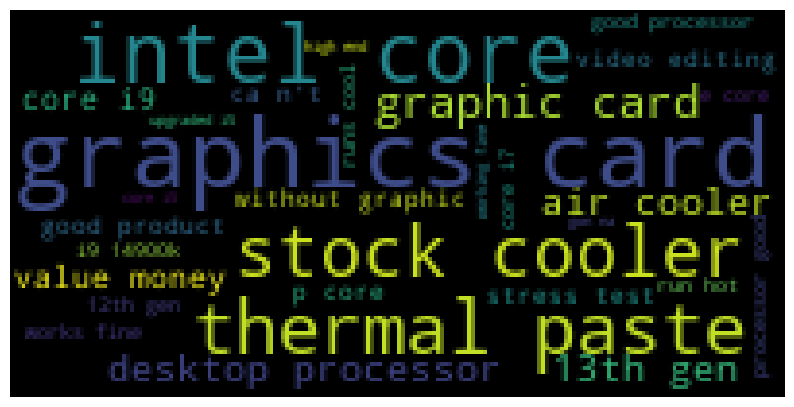

In [237]:
create_word_cloud(Sentiment=1)


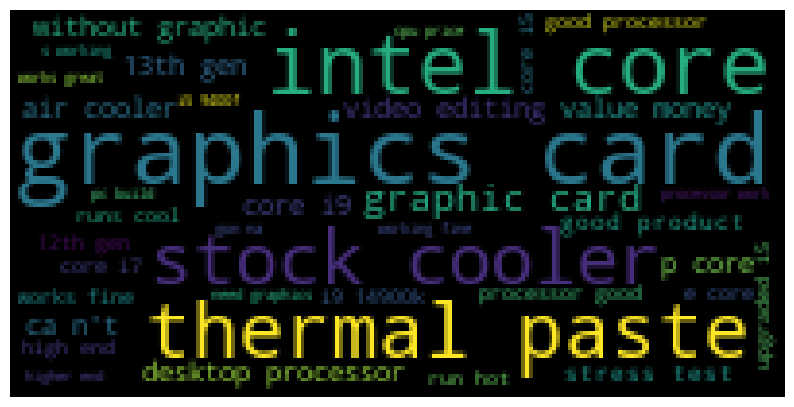

In [238]:
create_word_cloud(Sentiment=0)

21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step


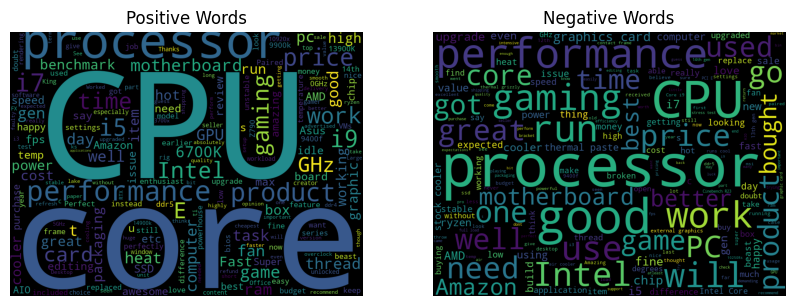

In [239]:
predictions = model2.predict(X_test_seq)  # Get probabilities for each sentiment class
predictions = np.argmax(predictions, axis=-1) 
# Initialize empty lists for positive and negative words
positive_words = []
negative_words = []

# Loop through reviews, predictions, and pre-trained embeddings (assuming you have them)
for review, sentiment, embedding in zip(df["Reviews"], predictions, X_test_seq):
  words = review.split()  # Split review into words
  embedding_list = embedding.tolist()  # Assuming embedding is a numpy array

  # Filter words based on predicted sentiment and embedding existence
  for word, word_embedding in zip(words, embedding_list):
    if word_embedding is not None:  # Check if embedding exists (optional)
      if sentiment == 1:  # Positive sentiment
        if word not in positive_words:  # Add unique words to list
          positive_words.append(word)
      else:  # Negative sentiment
        negative_words.append(word)

# Generate word clouds
positive_wordcloud = WordCloud(width=800, height=600).generate(" ".join(positive_words))
negative_wordcloud = WordCloud(width=800, height=600).generate(" ".join(negative_words))

# Display or save word clouds
plt.figure(figsize=(10, 6))
plt.subplot(121)
plt.imshow(positive_wordcloud)
plt.title('Positive Words')
plt.axis("off")

plt.subplot(122)
plt.imshow(negative_wordcloud)
plt.title('Negative Words')
plt.axis("off")

plt.show()

In [240]:
#Sentiment Analysis Of Model in display:
sentences = ["This movie was fantastic!", "I hated this restaurant.", "The weather is just okay today."]
sequences=tokenizer.texts_to_sequences(sentences)

preprocessed_sentences = sequence.pad_sequences(sequences, maxlen=maxlen)

# Get predictions
predictions = model2.predict(preprocessed_sentences)

# Show predictions
for sentence, prediction in zip(sentences, predictions):
  print(f"Sentence: {sentence}")
  print(f"Predicted Sentiment: {prediction}")  # Assuming prediction is the class label
  print("-" * 20)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
Sentence: This movie was fantastic!
Predicted Sentiment: [4.9410306e-04 9.9950588e-01]
--------------------
Sentence: I hated this restaurant.
Predicted Sentiment: [6.844949e-05 9.999316e-01]
--------------------
Sentence: The weather is just okay today.
Predicted Sentiment: [9.6597751e-07 9.9999905e-01]
--------------------
